In [2]:
import importlib
import numpy as np
import graph_analysis_functions as gaf
import pickle
importlib.reload(gaf)

<module 'graph_analysis_functions' from '/home/admin/Ana/MicroBrain/codes/Graph Analysis & by region/graph_analysis_functions.py'>

In [3]:
path = "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom.pkl"
res = np.array([1.625, 1.625, 2.5])
center = np.array([2100, 4200, 750])   # voxels
box_um = np.array([400, 400, 400])     # µm

box = gaf.make_box(center, box_um, res)

data = pickle.load(open(path, "rb"))

[make_box] size check (µm): x=400.00, y=400.00, z=400.00


In [51]:
import numpy as np
import matplotlib.pyplot as plt

def check_Redge_vs_geom_max_radius(
    data,
    edge_radius_attr="radius",   # atributo en graph.es con el radio por edge (si existe)
    tol_abs=1e-3,
    do_plots=True,
    bins=120,
    verbose=True
):
    """
    Compare:
      R_edge  (graph.es[edge_radius_attr])
    vs
      R_geom_max = max( data["geom"]["radii"][geom_start:geom_end] )  per edge

    Assumes:
      data["graph"] is igraph.Graph
      data["geom"]["radii"] exists (per geometry point)
      graph.es has "geom_start", "geom_end"
    """

    G = data["graph"]

    # --- sanity checks ---
    if "geom" not in data or "radii" not in data["geom"]:
        raise ValueError("Missing data['geom']['radii'].")

    if "geom_start" not in G.es.attributes() or "geom_end" not in G.es.attributes():
        raise ValueError("Edges must have attributes 'geom_start' and 'geom_end'.")

    if edge_radius_attr not in G.es.attributes():
        raise ValueError(
            f"Edge radius attribute '{edge_radius_attr}' not found in graph.es.\n"
            f"Available edge attrs: {G.es.attributes()}"
        )

    r_geom = np.asarray(data["geom"]["radii"], dtype=np.float64)
    r_edge = np.asarray(G.es[edge_radius_attr], dtype=np.float64)
    gs = np.asarray(G.es["geom_start"], dtype=np.int64)
    ge = np.asarray(G.es["geom_end"], dtype=np.int64)

    nE = G.ecount()
    if len(r_edge) != nE:
        raise ValueError(f"len(r_edge)={len(r_edge)} != nE={nE}")

    # --- compute R_geom_max per edge ---
    r_geom_max = np.full(nE, np.nan, dtype=np.float64)

    for ei in range(nE):
        s = int(gs[ei])
        t = int(ge[ei])

        # Expect [s, t) indexing; need at least 1 point
        if t <= s:
            continue
        if s < 0 or t > len(r_geom):
            continue

        seg = r_geom[s:t]
        if seg.size == 0:
            continue

        r_geom_max[ei] = np.nanmax(seg)

    # valid comparisons only where both finite
    m_valid = np.isfinite(r_edge) & np.isfinite(r_geom_max)
    if not np.any(m_valid):
        raise ValueError("No valid edges to compare (all r_edge or r_geom_max are non-finite).")

    dR = (r_edge[m_valid] - r_geom_max[m_valid])
    abs_dR = np.abs(dR)

    # --- global summary ---
    if verbose:
        print("\n=== Redge vs max(geom radius) ===")
        print(f"n edges (graph): {nE}")
        print(f"n compared (finite): {int(np.sum(m_valid))}")
        print(f"mean ΔR:   {np.mean(dR):.6g}")
        print(f"std  ΔR:   {np.std(dR):.6g}")
        print(f"max |ΔR|:  {np.max(abs_dR):.6g}")
        print(f"% |ΔR| < {tol_abs:g}: {100.0*np.mean(abs_dR < tol_abs):.2f}%")

    # --- bad edges ---
    m_bad = abs_dR >= tol_abs
    err_bad = abs_dR[m_bad]

    if verbose:
        print(f"Bad edges: {int(np.sum(m_bad))} ({100.0*np.mean(m_bad):.2f}%)")

        if err_bad.size == 0:
            print("No bad edges under this threshold (err_bad is empty).")
        else:
            print(f"Mean error:   {float(np.mean(err_bad)):.4f}")
            print(f"Median error: {float(np.median(err_bad)):.4f}")
            print(f"Max error:    {float(np.max(err_bad)):.4f}")

            # relative error (only where geom max > 0)
            denom = r_geom_max[m_valid][m_bad]
            m_pos = denom > 0
            if np.any(m_pos):
                rel = err_bad[m_pos] / denom[m_pos]
                print(f"Median relative error: {float(np.median(rel)*100):.2f}%")
                print(f"95th percentile rel error: {float(np.percentile(rel,95)*100):.2f}%")

    # --- plots ---
    if do_plots:
        plt.figure(figsize=(7,5))
        plt.hist(dR, bins=bins)
        plt.axvline(0, linestyle="--")
        plt.title("ΔR = R_edge - max(R_geom) (finite edges)")
        plt.xlabel("ΔR")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7,5))
        plt.hist(abs_dR, bins=bins)
        plt.axvline(tol_abs, linestyle="--")
        plt.title("|ΔR| distribution (finite edges)")
        plt.xlabel("|ΔR|")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    return {
        "nE": int(nE),
        "n_compared": int(np.sum(m_valid)),
        "dR": dR,
        "abs_dR": abs_dR,
        "bad_mask_valid": m_bad,
        "err_bad": err_bad,
        "tol_abs": float(tol_abs),
    }



=== Redge vs max(geom radius) ===
n edges (graph): 931
n compared (finite): 931
mean ΔR:   0.0747102
std  ΔR:   0.232668
max |ΔR|:  2.23607
% |ΔR| < 0.001: 86.25%
Bad edges: 128 (13.75%)
Mean error:   0.5434
Median error: 0.4882
Max error:    2.2361
Median relative error: 17.26%
95th percentile rel error: 43.05%


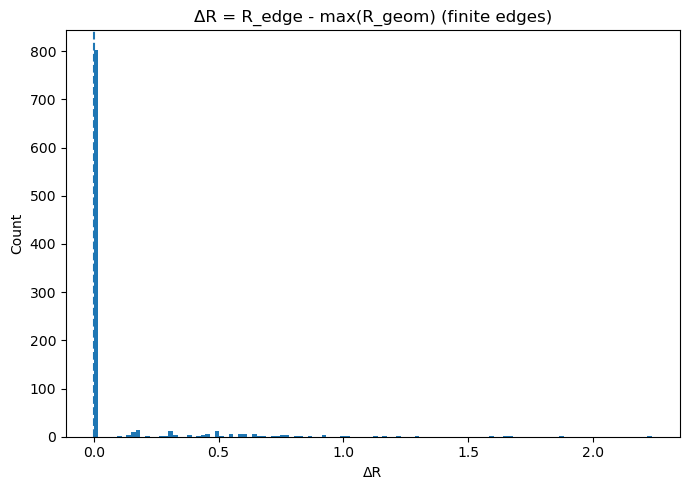

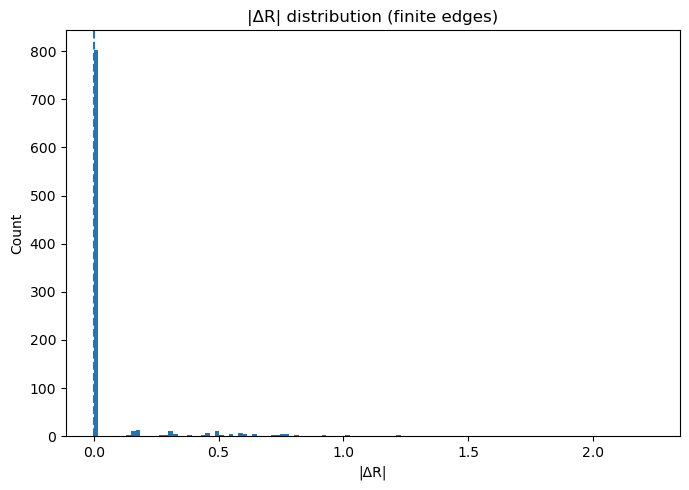

{'nE': 931,
 'n_compared': 931,
 'dR': array([0.55051017, 0.55051017, 0.        , 0.59235907, 0.76393199,
        0.        , 0.        , 0.5793798 , 0.55051017, 0.55051017,
        0.37893724, 1.87350047, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.55051017, 0.        , 0.4881978 ,
        0.        , 0.        , 0.63708925, 0.        , 0.59235907,
        2.23606801, 0.        , 0.        , 0.        , 0.        ,
        0.33385062, 0.        , 0.63567448, 0.63567448, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.7416575 , 0.        , 0.        , 0.        , 0.        ,
        0.

In [52]:
check_Redge_vs_geom_max_radius(data)

In [5]:
import numpy as np

def check_vertex_vs_geom_endpoint_diameters(data, tol=1e-3):
    G = data["graph"]

    # per-vertex diameters
    Dv = 2.0 * np.asarray(data["vertex"]["radii"], float)

    # per-geom-point diameters
    Dp = 2.0 * np.asarray(data["geom"]["radii"], float)

    gs = np.asarray(G.es["geom_start"], int)
    ge = np.asarray(G.es["geom_end"], int)

    # endpoints in geom index space
    p0 = gs
    p1 = ge - 1

    # endpoints vertices
    ends = np.asarray(G.get_edgelist(), int)
    u = ends[:, 0]
    v = ends[:, 1]

    # absolute errors at endpoints
    err_u = np.abs(Dp[p0] - Dv[u])
    err_v = np.abs(Dp[p1] - Dv[v])

    err_all = np.concatenate([err_u, err_v])

    print("\n=== Vertex diameter vs geom endpoint diameter ===")
    print("n edges:", G.ecount(), "| n endpoint comparisons:", len(err_all))
    print(f"% |ΔD| < {tol:g}: {100*np.mean(err_all < tol):.2f}%")
    print("Median |ΔD|:", float(np.median(err_all)))
    print("Max |ΔD|:", float(err_all.max()))

    bad = err_all >= tol
    if np.any(bad):
        print("Bad endpoints:", int(np.sum(bad)), f"({100*np.mean(bad):.2f}%)")

    return {
        "err_u": err_u,
        "err_v": err_v,
        "err_all": err_all
    }
check_vertex_vs_geom_endpoint_diameters(data)




=== Vertex diameter vs geom endpoint diameter ===
n edges: 4620894 | n endpoint comparisons: 9241788
% |ΔD| < 0.001: 100.00%
Median |ΔD|: 0.0
Max |ΔD|: 0.0

=== Vertex diameter vs geom endpoint diameter (allow swap) ===
n edges: 4620894
% best |ΔD| < 0.001: 100.00%
Median best |ΔD|: 0.0
Max best |ΔD|: 0.0
Bad edges after allowing swap: 0 (0.00%)
Edges where SWAP fits better than DIRECT: 0 (0.00%)


{'direct': array([0., 0., 0., ..., 0., 0., 0.], shape=(4620894,)),
 'swap': array([4.65488791, 3.05627632, 1.17157292, ..., 3.65685415, 6.        ,
        2.34314585], shape=(4620894,)),
 'best': array([0., 0., 0., ..., 0., 0., 0.], shape=(4620894,)),
 'is_swap_better': array([False, False, False, ..., False, False, False], shape=(4620894,)),
 'bad_mask': array([False, False, False, ..., False, False, False], shape=(4620894,))}

In [59]:
G = data["graph"]
print(G.es.attributes())

['nkind', 'radius', 'diameter', 'length', 'geom_start', 'geom_end', 'length_tortuous', 'tortuosity']


In [25]:
import numpy as np

def check_Redge_vs_geom_max_radius(data):
    """
    Check whether edge radius Redge equals the maximum radius
    of its polyline geometry.

    data structure:
      data["graph"] -> igraph Graph
      data["geom"]["radii"] OR data["geom"]["diameters"]
    """

    G = data["graph"]
    geom = data["geom"]

    # --- edge radius ---
    if "radius" not in G.es.attributes():
        raise ValueError("G.es['radius'] missing")
    Redge = np.asarray(G.es["radius"], dtype=float)

    # --- geom radii ---
    if "radii" in geom:
        r_geom = np.asarray(geom["radii"], dtype=float)
    elif "diameters" in geom:
        r_geom = 0.5 * np.asarray(geom["diameters"], dtype=float)
    else:
        raise ValueError("Need geom['radii'] or geom['diameters']")

    gs = np.asarray(G.es["geom_start"], dtype=int)
    ge = np.asarray(G.es["geom_end"], dtype=int)

    Rmax = np.zeros(G.ecount(), dtype=float)

    for e in range(G.ecount()):
        s, t = gs[e], ge[e]
        if t > s:
            Rmax[e] = np.max(r_geom[s:t])
        else:
            Rmax[e] = np.nan

    dR = Redge - Rmax
    dR = dR[np.isfinite(dR)]

    print("\n=== Redge vs max(geom radius) ===")
    print(f"n edges: {len(dR)}")
    print(f"mean ΔR:   {np.mean(dR):.6g}")
    print(f"std ΔR:    {np.std(dR):.6g}")
    print(f"max |ΔR|:  {np.max(np.abs(dR)):.6g}")
    print(f"% |ΔR| < 1e-3: {100*np.mean(np.abs(dR) < 1e-3):.2f}%")

    err = np.abs(dR)
    
    mask_bad = err > 1e-3
    err_bad = err[mask_bad]
    
    print(f"Bad edges: {len(err_bad)} ({100*len(err_bad)/len(dR):.2f}%)")
    print(f"Mean error: {err_bad.mean():.4f}")
    print(f"Median error: {np.median(err_bad):.4f}")
    print(f"Max error: {err_bad.max():.4f}")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(7,5))
    plt.hist(err_bad, bins=30, edgecolor="black")
    plt.xlabel("|Redge − max(r_geom)|")
    plt.ylabel("Number of edges")
    plt.title("Absolute radius error for mismatching edges (~13%)")
    plt.tight_layout()
    plt.show()

    err_rel = err_bad / Redge[mask_bad]

    print(f"Median relative error: {np.median(err_rel)*100:.2f}%")
    print(f"95th percentile rel error: {np.percentile(err_rel,95)*100:.2f}%")
    
    plt.figure(figsize=(7,5))
    plt.hist(err_rel*100, bins=30, edgecolor="black")
    plt.xlabel("Relative error (%)")
    plt.ylabel("Number of edges")
    plt.title("Relative radius error (mismatching edges)")
    plt.tight_layout()
    plt.show()



    return dR


In [26]:
check_Redge_vs_geom_max_radius(data)



=== Redge vs max(geom radius) ===
n edges: 4620894
mean ΔR:   0
std ΔR:    0
max |ΔR|:  0
% |ΔR| < 1e-3: 100.00%
Bad edges: 0 (0.00%)
Mean error: nan
Median error: nan


/tmp/ipykernel_83274/1318113435.py:57: RuntimeWarning: Mean of empty slice.
  print(f"Mean error: {err_bad.mean():.4f}")
/home/admin/miniconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/admin/miniconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


ValueError: zero-size array to reduction operation maximum which has no identity

In [47]:
# Radii sanity 

if "geom" in data and "radii" in data["geom"]:
    data["radii_geom"] = data["geom"]["radii"]

if "vertex" in data and "radii" in data["vertex"]:
    data["graph"].vs["radii"] = data["vertex"]["radii"]

gaf.check_polyline_radii_match_endnodes(data)
gaf.check_polyline_radii_variation(data)
gaf.classify_edge_endpoint_coords(data)




gaf.analyze_hdn_pattern(data, box, coords_attr="coords_image", degree_thr=4, face_eps=2.0)


=== Radii check: polyline endpoints vs node radii ===
Node radius attr used: 'radii' | tol=0.001
Mismatching edges: 230 / 931 | max diff: 3.2762
Examples (edge, maxdiff, rA, r_poly0, rB, r_polyEnd):
  (8, 0.21342182159423828, 2.4494898319244385, 2.2360680103302, 2.4494898319244385, 2.4494898319244385)
  (9, 0.21342182159423828, 2.4494898319244385, 2.2360680103302, 2.4494898319244385, 2.4494898319244385)
  (12, 2.2409260272979736, 4.690415859222412, 2.4494898319244385, 4.690415859222412, 4.690415859222412)
  (13, 2.0065724849700928, 4.242640495300293, 2.2360680103302, 4.242640495300293, 4.242640495300293)
  (17, 0.4494898319244385, 2.0, 2.4494898319244385, 2.0, 2.0)
  (18, 0.5923590660095215, 2.2360680103302, 2.8284270763397217, 2.2360680103302, 2.2360680103302)
  (20, 0.5923590660095215, 2.2360680103302, 2.8284270763397217, 2.2360680103302, 2.2360680103302)
  (21, 0.5923590660095215, 2.8284270763397217, 2.2360680103302, 2.8284270763397217, 2.8284270763397217)
  (22, 0.6055512428283691

AttributeError: 'dict' object has no attribute 'vs'

In [10]:
import pickle
import numpy as np

# Cargar tu archivo
with open("/home/admin/Ana/MicroBrain/output/graph_18_OutGeom.pkl", "rb") as f:
    data = pickle.load(f)

G = data["graph"]
geom_radii = data["geom"]["radii"]

# Vamos a probar con el eje índice 0
e_idx = 43
s = G.es[e_idx]["geom_start"]
en = G.es[e_idx]["geom_end"]

# Valor escalar vs Máximo de la geometría
scalar_val = G.es[e_idx]["radius"]
geometry_segment = geom_radii[s:en]
max_val = np.max(geometry_segment)

print(f"Eje {e_idx}:")
print(f"  Escalar en el grafo: {scalar_val}")
print(f"  Máximo en la geometría: {max_val}")
print(f"  ¿Coinciden?: {np.isclose(scalar_val, max_val)}")


Eje 43:
  Escalar en el grafo: 2.8284270763397217
  Máximo en la geometría: 2.8284270763397217
  ¿Coinciden?: True


In [11]:
gaf.edge_radius_consistency_report(data, sample=200_000, seed=0)

AttributeError: module 'graph_analysis_functions' has no attribute 'edge_radius_consistency_report'

In [12]:
import numpy as np
import matplotlib as plt
def compare_edge_radius_definitions(data, sample=200_000, seed=0):
    G = data["graph"]
    rg = np.asarray(data["geom"]["radii"], np.float64)
    rv = np.asarray(data["vertex"]["radii"], np.float64)
    edges = np.asarray(G.get_edgelist(), np.int64)

    gs = np.asarray(G.es["geom_start"], np.int64)
    ge = np.asarray(G.es["geom_end"], np.int64)
    re = np.asarray(G.es["radius"], np.float64)  # radii_edge from CSV

    nE = G.ecount()
    rng = np.random.default_rng(seed)
    idx = rng.choice(nE, size=min(sample, nE), replace=False)

    u = edges[idx,0]; v = edges[idx,1]
    s = gs[idx]; e = ge[idx] - 1

    r_endpoints = 0.5*(rg[s] + rg[e])
    r_vertices  = 0.5*(rv[u] + rv[v])

    # mean/median/max along polyline (careful: variable length => loop)
    r_mean = np.empty_like(r_endpoints)
    r_med  = np.empty_like(r_endpoints)
    r_max  = np.empty_like(r_endpoints)

    for k, ei in enumerate(idx):
        a = gs[ei]; b = ge[ei]
        rr = rg[a:b]
        r_mean[k] = np.mean(rr)
        r_med[k]  = np.median(rr)
        r_max[k]  = np.max(rr)

    def stats(name, pred):
        d = re[idx] - pred
        absd = np.abs(d)
        print(f"\n{name}")
        print(f"  RMSE={np.sqrt(np.mean(d*d)):.6f}  MAE={np.mean(absd):.6f}  MAX={np.max(absd):.6f}")
        print(f"  % exact (|Δ|==0): {100*np.mean(absd==0):.2f}%")
        for t in [1e-3, 1e-2, 5e-2, 1e-1]:
            print(f"  % |Δ|<={t}: {100*np.mean(absd<=t):.2f}%")
        return d

    d1 = stats("endpoint-average (geom endpoints)", r_endpoints)
    d2 = stats("vertex-average", r_vertices)
    d3 = stats("mean(points)", r_mean)
    d4 = stats("median(points)", r_med)
    d5 = stats("max(points)", r_max)

    return {
        "idx": idx,
        "d_endpoint": d1,
        "d_vertex": d2,
        "d_mean": d3,
        "d_median": d4,
        "d_max": d5,
    }

def plot_delta_hist(delta, title="Δr = r_edge - r_pred", bins=200):
    delta = np.asarray(delta)
    plt.figure()
    plt.hist(delta, bins=bins)
    plt.title(title)
    plt.xlabel("Δr")
    plt.ylabel("count")
    plt.show()

In [13]:
res = compare_edge_radius_definitions(data, sample=200_000)
plot_delta_hist(res["d_endpoint"], "Δr vs endpoint-average")
plot_delta_hist(res["d_max"], "Δr vs max(points)")



endpoint-average (geom endpoints)
  RMSE=0.646638  MAE=0.444364  MAX=18.710068
  % exact (|Δ|==0): 6.87%
  % |Δ|<=0.001: 6.87%
  % |Δ|<=0.01: 6.87%
  % |Δ|<=0.05: 6.92%
  % |Δ|<=0.1: 14.69%

vertex-average
  RMSE=0.646638  MAE=0.444364  MAX=18.710068
  % exact (|Δ|==0): 6.87%
  % |Δ|<=0.001: 6.87%
  % |Δ|<=0.01: 6.87%
  % |Δ|<=0.05: 6.92%
  % |Δ|<=0.1: 14.69%

mean(points)
  RMSE=0.928645  MAE=0.726977  MAX=25.502220
  % exact (|Δ|==0): 0.95%
  % |Δ|<=0.001: 0.95%
  % |Δ|<=0.01: 0.95%
  % |Δ|<=0.05: 1.15%
  % |Δ|<=0.1: 2.09%

median(points)
  RMSE=1.001658  MAE=0.755225  MAX=32.349793
  % exact (|Δ|==0): 3.45%
  % |Δ|<=0.001: 3.45%
  % |Δ|<=0.01: 3.45%
  % |Δ|<=0.05: 3.46%
  % |Δ|<=0.1: 4.04%

max(points)
  RMSE=0.000000  MAE=0.000000  MAX=0.000000
  % exact (|Δ|==0): 100.00%
  % |Δ|<=0.001: 100.00%
  % |Δ|<=0.01: 100.00%
  % |Δ|<=0.05: 100.00%
  % |Δ|<=0.1: 100.00%


TypeError: 'module' object is not callable

In [14]:
    # Mejor: crea subgrafo del box y solo a ese le pones coords
    sub = gaf.subgraph_in_box(data, box, coords_attr="coords_image")  # si tienes algo así
    subG = sub["graph"]
    subG.vs["coords_image"] = sub["vertex"]["coords_image"].tolist()
    gaf.plot_redundancy_used_edges(subG, box, res_red["used_edges_orig"], coords_attr="coords_image")


AttributeError: module 'graph_analysis_functions' has no attribute 'subgraph_in_box'

In [16]:


# 1) grafo (igraph)
data = gaf.load_graph(
    "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom.pkl"
)

path_outgeom = "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom_Hcut3.pkl"

G = data["graph"]

res = np.array([1.625, 1.625, 2.5])
center = np.array([1000, 3500, 1400])   # voxels
box_um = np.array([400, 400, 400])     # µm

box = gaf.make_box(center, box_um, res)



res_bc = gaf.analyze_bc_faces(G, box, coords_attr="coords_image", eps=2.0, degree_thr=4)
gaf.plot_bc_cube_net(res_bc)
gaf.plot_bc_three_views_custom(G, res_bc, box, coords_attr="coords_image")

# 3) Grados
gaf.degree_summary(G)
gaf.degree_summary_by_type(G)
gaf.plot_degree_nodes_spatial(G, coords_attr="coords_image", degree_min=4)      # HDN
gaf.plot_degree_nodes_spatial(G, coords_attr="coords_image", degree_min=1, degree_max=1)

# 4) Redundancia real A->V (edge-disjoint)
res_red = gaf.edge_disjoint_av_paths_in_box(G, box, coords_attr="coords_image")
print(res_red)

# 5) Vessel density Gaia-style (necesita data OutGeom-like dict)
data = pickle.load(open(path_outgeom, "rb"))
ms = gaf.microsegments_from_outgeom(data)
gaf.count_microsegments_by_nkind(ms)
df_vd = gaf.vessel_density_slabs_in_box(ms, box, slab=50.0, axis="z", use_volume_fraction=False)

# 6) Radii sanity
gaf.check_polyline_radii_match_endnodes(data)
gaf.check_polyline_radii_variation(data)


[make_box] size check (µm): x=400.00, y=400.00, z=400.00


ValueError: Missing vertex attribute 'coords_image'. Available vertex attrs: ['id']

In [ ]:
path = "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom.pkl"
res = np.array([1.625, 1.625, 2.5])
center = np.array([2100, 4200, 750])   # voxels
box_um = np.array([400, 400, 400])     # µm

box = gaf.make_box(center, box_um, res)

data = pickle.load(open(path, "rb"))

# 1) GC
data = gaf.select_largest_component_data(data, verbose=True)

# 2) pasar attrs del data["vertex"] a graph.vs (para que TODO tu código actual funcione igual)
data = gaf.attach_vertex_attrs_from_data(data, verbose=False)
G = data["graph"]

# 3) tu análisis normal (sin tocarlo)
# single_connected_component(G) etc...

# 4) check radii endpoints
gaf.check_endpoint_radii_vertex_vs_geom(data, tol=1e-3, verbose=True)

# 5) redundancia + viz
res_red = gaf.edge_disjoint_av_paths_in_box_with_used_edges(G, box, coords_attr="coords_image")
print(res_red)

gaf.plot_redundancy_used_edges(G, box, res_red["used_edges_orig"], coords_attr="coords_image")

# 6) HDN pattern
gaf.analyze_hdn_pattern(G, box, coords_attr="coords_image", degree_thr=4, face_eps=2.0)

gaf.check_radii_endpoints_allow_swap(data, tol=1e-3, max_examples=10, use_coords_check=True, coords_tol=1e-6)
gaf.check_polyline_radii_variation(data, tol_rel=0.05, verbose=True)

#gaf.debug_edge(data, 10)
#gaf.debug_edge(data, 11)

gaf.classify_edge_endpoint_coords(data, tol=1e-6)


In [ ]:
gaf.check_radii_endpoints_allow_swap(data, tol=1e-3, max_examples=10, use_coords_check=True, coords_tol=1e-6)
gaf.check_polyline_radii_variation(data, tol_rel=0.05, verbose=True)

#gaf.debug_edge(data, 10)
#gaf.debug_edge(data, 11)

gaf.classify_edge_endpoint_coords(data, tol=1e-6)

In [ ]:
import numpy as np

def debug_bad_edges_endpoints(data, bad_edge_ids, atol_pos=1e-6, topk=20):
    """
    data: NEW PKL dict: {"graph":G, "vertex":..., "geom":...}
    bad_edge_ids: list/array of edge indices to inspect
    """
    G = data["graph"]

    # geom arrays
    x = np.asarray(data["geom"]["x"], float)
    y = np.asarray(data["geom"]["y"], float)
    z = np.asarray(data["geom"]["z"], float)
    r_geom = np.asarray(data["geom"]["radii"], float) if "radii" in data["geom"] else None

    # vertex arrays
    coords_v = np.asarray(data["vertex"]["coords_image"], float)
    r_v = np.asarray(data["vertex"]["radii"], float) if "radii" in data["vertex"] else None

    if r_geom is None or r_v is None:
        raise ValueError("Need data['geom']['radii'] and data['vertex']['radii'] for this debug.")

    bad_edge_ids = list(map(int, bad_edge_ids))[:topk]

    print("\n=== DEBUG: geom endpoints vs node coords + radii ===")
    print(f"Checking {len(bad_edge_ids)} edges (showing up to topk={topk})")
    print("Columns:")
    print(" e | u->v | ||P0-cu||  ||Pend-cv|| | r_u - rP0 | r_v - rPend | P0==cu? Pend==cv?")

    for eidx in bad_edge_ids:
        e = G.es[eidx]
        u, v = map(int, e.tuple)

        s = int(e["geom_start"])
        t = int(e["geom_end"])
        if (t - s) < 2:
            continue

        P0 = np.array([x[s], y[s], z[s]], float)
        Pend = np.array([x[t-1], y[t-1], z[t-1]], float)

        cu = coords_v[u].astype(float)
        cv = coords_v[v].astype(float)

        d0 = float(np.linalg.norm(P0 - cu))
        d1 = float(np.linalg.norm(Pend - cv))

        ru = float(r_v[u])
        rv = float(r_v[v])
        r0 = float(r_geom[s])
        r1 = float(r_geom[t-1])

        dr0 = abs(ru - r0)
        dr1 = abs(rv - r1)

        ok0 = (d0 <= atol_pos)
        ok1 = (d1 <= atol_pos)

        print(f"{eidx:4d} | {u:4d}->{v:4d} | {d0:10.6g} {d1:10.6g} |"
              f" {dr0:9.6g} {dr1:9.6g} | {ok0} {ok1}")

    print("\nTip:")
    print(" si ves d0/d1 grandes -> el endpoint geom NO es el nodo (problema de endpoints/orientación).")
    print("si d0/d1 ~0 pero dr0/dr1 grandes -> radii vertex != radii geom (definición distin")


In [ ]:
# por ejemplo, si tu check te devolvió algo como:
# res = check_radii_endpoints_newpkl(...)
# bad_edge_ids = [ex[0] for ex in res["examples"]]  # o tu lista completa

debug_bad_edges_endpoints(data, bad_edge_ids, atol_pos=1e-6, topk=20)


## CHECK EDGE RADII CALCULATION (verteces_rad/2)

In [ ]:
import numpy as np

def infer_edge_radius_rule(data, sample=200_000, seed=0, eps=1e-12, verbose=True):
    """
    Compara r_edge (G.es['radius']) con distintas hipótesis calculadas
    desde radii por punto (geom) y radii por vértice (vertex).
    Devuelve un ranking por RMSE / MAE / max error.

    sample: número de edges a muestrear (para ir rápido). Pon None para todos.
    """

    G = data["graph"]
    r_edge = np.asarray(G.es["radius"], dtype=np.float32)

    gs = np.asarray(G.es["geom_start"], dtype=np.int64)
    ge = np.asarray(G.es["geom_end"], dtype=np.int64)

    r_geom = np.asarray(data["geom"]["radii"], dtype=np.float32)
    v_r    = np.asarray(data["vertex"]["radii"], dtype=np.float32)

    nE = G.ecount()

    # --- sample edges for speed ---
    rng = np.random.default_rng(seed)
    if sample is None or sample >= nE:
        idxE = np.arange(nE, dtype=np.int64)
    else:
        idxE = rng.choice(nE, size=sample, replace=False).astype(np.int64)

    # filtros básicos (edges con >=2 puntos y r_edge finito)
    s = gs[idxE]
    e = ge[idxE]
    ok = (e - s >= 2) & np.isfinite(r_edge[idxE])
    idxE = idxE[ok]
    s = gs[idxE]
    e = ge[idxE]

    # endpoints (puntos)
    rg0 = r_geom[s]
    rg1 = r_geom[e - 1]

    # vertices
    u = np.fromiter((G.es[int(i)].source for i in idxE), dtype=np.int64, count=len(idxE))
    v = np.fromiter((G.es[int(i)].target for i in idxE), dtype=np.int64, count=len(idxE))
    rv_u = v_r[u]
    rv_v = v_r[v]

    # --- helpers de stats ---
    def stats(name, pred):
        diff = (pred - r_edge[idxE]).astype(np.float64)
        mae  = float(np.mean(np.abs(diff)))
        rmse = float(np.sqrt(np.mean(diff * diff)))
        mx   = float(np.max(np.abs(diff)))
        # % exactos (útil si hay cuantización tipo sqrt(n))
        exact = float(np.mean(np.abs(diff) < 1e-6) * 100.0)
        return {"name": name, "MAE": mae, "RMSE": rmse, "MAX": mx, "%exact": exact}

    results = []

    # H3: mean endpoints (points)
    results.append(stats("mean(points endpoints) = (rg[s]+rg[e-1])/2", 0.5*(rg0 + rg1)))

    # H4: mean vertices
    results.append(stats("mean(vertices) = (rv[u]+rv[v])/2", 0.5*(rv_u + rv_v)))

    # H1/H2: mean/median of all point radii along edge
    # (lo hacemos en bucle porque cada edge tiene longitud distinta)
    pred_mean = np.empty(len(idxE), dtype=np.float32)
    pred_med  = np.empty(len(idxE), dtype=np.float32)

    for k, ei in enumerate(idxE):
        ss = int(gs[ei]); ee = int(ge[ei])
        seg = r_geom[ss:ee]
        pred_mean[k] = float(np.mean(seg))
        pred_med[k]  = float(np.median(seg))

    results.append(stats("mean(points) = mean(r_geom[s:e])", pred_mean))
    results.append(stats("median(points) = median(r_geom[s:e])", pred_med))

    # Opcional: weighted by segment length if you have lengths2 (per point)
    if "lengths2" in data["geom"]:
        L2 = np.asarray(data["geom"]["lengths2"], dtype=np.float32)
        pred_wmean = np.empty(len(idxE), dtype=np.float32)
        for k, ei in enumerate(idxE):
            ss = int(gs[ei]); ee = int(ge[ei])
            # segmentos: ss..ee-2 (si tu L2 tiene último=0 por edge, esto lo maneja)
            w = L2[ss:ee]
            rr = r_geom[ss:ee]
            sw = float(np.sum(w))
            if sw < eps:
                pred_wmean[k] = float(np.mean(rr))
            else:
                pred_wmean[k] = float(np.sum(rr * w) / sw)
        results.append(stats("length-weighted mean(points)", pred_wmean))

    # ranking por RMSE
    results_sorted = sorted(results, key=lambda d: d["RMSE"])

    if verbose:
        print(f"Edges tested: {len(idxE):,} (sample={sample})")
        print("Ranking (best first):")
        for r in results_sorted:
            print(f"- {r['name']}")
            print(f"    RMSE={r['RMSE']:.6g}  MAE={r['MAE']:.6g}  MAX={r['MAX']:.6g}  exact={r['%exact']:.2f}%")

    return results_sorted


In [ ]:
import pickle
data = pickle.load(open("/home/admin/Ana/MicroBrain/output/graph_18_OutGeom.pkl", "rb"))

res = infer_edge_radius_rule(data, sample=200_000, seed=0)
best = res[0]
print("\nBEST GUESS:", best["name"])
